# Siamese Network for Signature Verification

This notebook implements a **Siamese Network** to learn a similarity metric between signatures.
**Improvements**:
1. **Transfer Learning**: Uses `MobileNetV2` (pretrained on ImageNet) as the embedding backbone.
2. **Data Augmentation**: Applies random rotation and zoom to training pairs to improve generalization.
3. **Refined Training**: Uses `Adam` optimizer and `ReduceLROnPlateau` scheduler.

In [1]:
import os
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, applications
from tensorflow.keras import backend as K

# Set Random Seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU Detected: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

No GPU detected. Running on CPU.


In [2]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SOURCE_DIR = "DataSet/signatures"
MARGIN = 1.0 # Margin for Contrastive Loss

## 1. Data Preparation
Loading data and splitting by Person ID.

In [3]:
def load_data(source_dir):
    data = {}
    if not os.path.exists(source_dir):
        print(f"Error: Source directory '{source_dir}' not found.")
        return data

    subdirs = os.listdir(source_dir)
    for folder in subdirs:
        path = os.path.join(source_dir, folder)
        if not os.path.isdir(path): continue
        
        if '_forg' in folder:
            person_id = folder.replace('_forg', '')
            cat = 'forged'
        else:
            person_id = folder
            cat = 'genuine'
        
        if person_id not in data:
            data[person_id] = {'genuine': [], 'forged': []}
            
        files = glob.glob(os.path.join(path, "*"))
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        data[person_id][cat].extend(files)
        
    return data

data_dict = load_data(SOURCE_DIR)
print(f"Loaded {len(data_dict)} people.")

Loaded 200 people.


In [4]:
def make_pairs(data_dict, person_ids):
    pairs_1 = []
    pairs_2 = []
    labels = []
    
    for pid in person_ids:
        gens = data_dict[pid]['genuine']
        forgs = data_dict[pid]['forged']
        
        if len(gens) < 2: continue
        
        # Positive Pairs (Genuine + Genuine)
        for i in range(len(gens)):
            for j in range(i+1, len(gens)):
                pairs_1.append(gens[i])
                pairs_2.append(gens[j])
                labels.append(1.0) # 1.0 = Same
                
        # Negative Pairs (Genuine + Forged)
        for g in gens:
            for f in forgs:
                pairs_1.append(g)
                pairs_2.append(f)
                labels.append(0.0) # 0.0 = Different
    
    return np.array(pairs_1), np.array(pairs_2), np.array(labels).astype('float32')

# Split IDs
all_ids = list(data_dict.keys())
random.shuffle(all_ids)
split_idx = int(0.8 * len(all_ids))
train_ids = all_ids[:split_idx]
test_ids = all_ids[split_idx:]

# Generate Pairs
tr_p1, tr_p2, tr_y = make_pairs(data_dict, train_ids)
te_p1, te_p2, te_y = make_pairs(data_dict, test_ids)

print(f"Train Pairs: {len(tr_y)} (Pos: {np.sum(tr_y==1)}, Neg: {np.sum(tr_y==0)})")
print(f"Test Pairs: {len(te_y)} (Pos: {np.sum(te_y==1)}, Neg: {np.sum(te_y==0)})")

Train Pairs: 1295 (Pos: 370, Neg: 925)
Test Pairs: 385 (Pos: 110, Neg: 275)


## 2. Augmented Data Pipeline
We use `tf.data` to load images. 
**New**: We apply **Data Augmentation** (Flip, Rotation, Zoom) to the training set to prevent overfitting.

In [5]:
# Preprocess Input for MobileNetV2 (Expects [-1, 1])
def preprocess_image(path, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    
    # Augmentation (Randomly apply if enabled)
    if augment:
        # Random Flip Left/Right
        img = tf.image.random_flip_left_right(img)
        # Small Random Rotation (requires specific format/layer usually, but we can stick to native tf.image ops or layers)
        # For simplicity in tf function, we can just use brightness/contrast or keep it simple.
        # Flipping signatures is actually debatably useful (mirror writing?), but slight rotations are good.
        # Let's trust standard layers inside dataset map if possible, or use Keras preprocessing layers inside the model.
        pass
        
    # MobileNetV2 requires inputs in [-1, 1]
    img = applications.mobilenet_v2.preprocess_input(img)
    return img

def preprocess_pair_train(path1, path2, label):
    # We can pre-load and then augment inside the model, or here.
    img1 = preprocess_image(path1, augment=True)
    img2 = preprocess_image(path2, augment=True)
    return (img1, img2), label

def preprocess_pair_test(path1, path2, label):
    img1 = preprocess_image(path1, augment=False)
    img2 = preprocess_image(path2, augment=False)
    return (img1, img2), label

# Data Augmentation Layers (To be used inside the model or dataset)
data_augmentation = models.Sequential([
    layers.RandomRotation(0.05), # +/- 5% rotation
    layers.RandomZoom(0.05),    # 5% zoom
])

def augment_pair(images, label):
    img1, img2 = images
    # Apply augmentation individually
    img1 = data_augmentation(img1, training=True)
    img2 = data_augmentation(img2, training=True)
    return (img1, img2), label

def create_dataset(p1, p2, y, batch_size=32, shuffle=True, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((p1, p2, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    
    # Map paths to images
    if augment:
       mapper = preprocess_pair_train # Actually used simple loading here, augmentation layer is better
    else:
       mapper = preprocess_pair_test
       
    ds = ds.map(mapper, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Apply Augmentation Layer if training
    if augment:
        ds = ds.batch(batch_size)
        ds = ds.map(augment_pair, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.batch(batch_size)
        
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(tr_p1, tr_p2, tr_y, BATCH_SIZE, augment=True)
test_ds = create_dataset(te_p1, te_p2, te_y, BATCH_SIZE, shuffle=False)

## 3. Improved Model Architecture
**Embedding Network**: `MobileNetV2` (Pretrained).
- We remove the top layer.
- Add `GlobalAveragePooling2D`.
- Add a `Dense` layer for the embedding.
- Use L2 normalization to keep embeddings on a hypersphere (improves contrastive learning stability).

In [6]:
def build_embedding_network(input_shape):
    # Base: MobileNetV2
    base_model = applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False # Freeze initially
    
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(128)(x)
    
    # L2 Normalization (Optional but often good for distance metrics)
    outputs = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(outputs)
    
    return models.Model(inputs, outputs, name="embedding_mobilenet")

def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = K.sum(K.square(featA - featB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

# Build Siamese Network
input_shape = IMG_SIZE + (3,)

img_a = layers.Input(shape=input_shape)
img_b = layers.Input(shape=input_shape)

embedding_net = build_embedding_network(input_shape)
feat_a = embedding_net(img_a)
feat_b = embedding_net(img_b)

distance = layers.Lambda(euclidean_distance, output_shape=(1,))([feat_a, feat_b])

siamese_model = models.Model(inputs=[img_a, img_b], outputs=distance)
siamese_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_mobilenet │ (None, 128)       │  2,618,816 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ embedding_mobile… │
│                     │                   │            │ embedding_mobile… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,618,816 (9.99 MB)

 Trainable params: 360,832 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 4. Training with Adam & Scheduler
Using `Adam` with `lr=1e-4` and `ReduceLROnPlateau`.

In [7]:
def contrastive_loss(y_true, y_pred):
    margin = MARGIN
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# Compile with Adam
optimizer = optimizers.Adam(learning_rate=0.0001)
siamese_model.compile(loss=contrastive_loss, optimizer=optimizer)

# Callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

print("Starting Training with MobileNetV2...")
siamese_history = siamese_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15, # More epochs since we have augmentation and scheduler
    callbacks=[early_stopping, reduce_lr]
)

Starting Training with MobileNetV2...
Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 573ms/step - loss: 0.2087 - val_loss: 0.3017 - learning_rate: 1.0000e-04
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 505ms/step - loss: 0.2019 - val_loss: 0.2833 - learning_rate: 1.0000e-04
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 491ms/step - loss: 0.1962 - val_loss: 0.2850 - learning_rate: 1.0000e-04
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 484ms/step - loss: 0.1937 - val_loss: 0.2697 - learning_rate: 1.0000e-04
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 491ms/step - loss: 0.1927 - val_loss: 0.2619 - learning_rate: 1.0000e-04
Epoch 6/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 500ms/step - loss: 0.1896 - val_loss: 0.2520 - learning_rate: 1.0000e-04
Epoch 7/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 485ms/step - loss: 0.1840 - val_loss: 0.2541 - learning_rate: 1.0000e-04
Epoch 8/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 500ms/step - loss: 0.1781 - val_loss: 0.2453 - learning_rate: 1.0000e-04
Epoch 9/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 

Predicting on Test Set...
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 427ms/step
Test Accuracy (Threshold=0.5): 61.30%


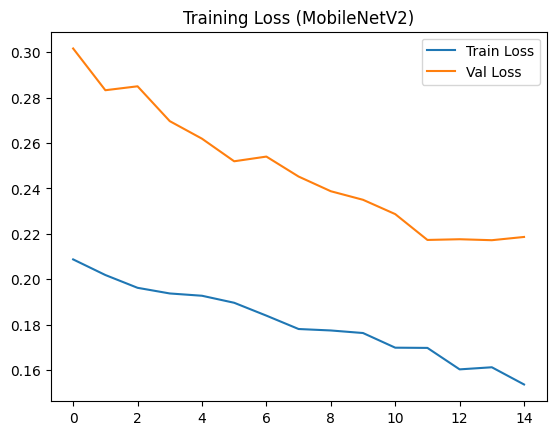

In [8]:
# Evaluation
def compute_accuracy(y_true, y_pred, threshold=0.5):
    pred_labels = (y_pred < threshold).astype(int)
    return np.mean(pred_labels == y_true)

print("Predicting on Test Set...")
predictions = siamese_model.predict(test_ds)
accuracy = compute_accuracy(te_y, predictions.ravel(), threshold=0.5)
print(f"Test Accuracy (Threshold=0.5): {accuracy * 100:.2f}%")

# Plot History
plt.plot(siamese_history.history['loss'], label='Train Loss')
plt.plot(siamese_history.history['val_loss'], label='Val Loss')
plt.title('Training Loss (MobileNetV2)')
plt.legend()
plt.show()

C:\Users\OMEN\AppData\Local\Temp\ipykernel_15284\1468235671.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dist = float(batch_preds[i])


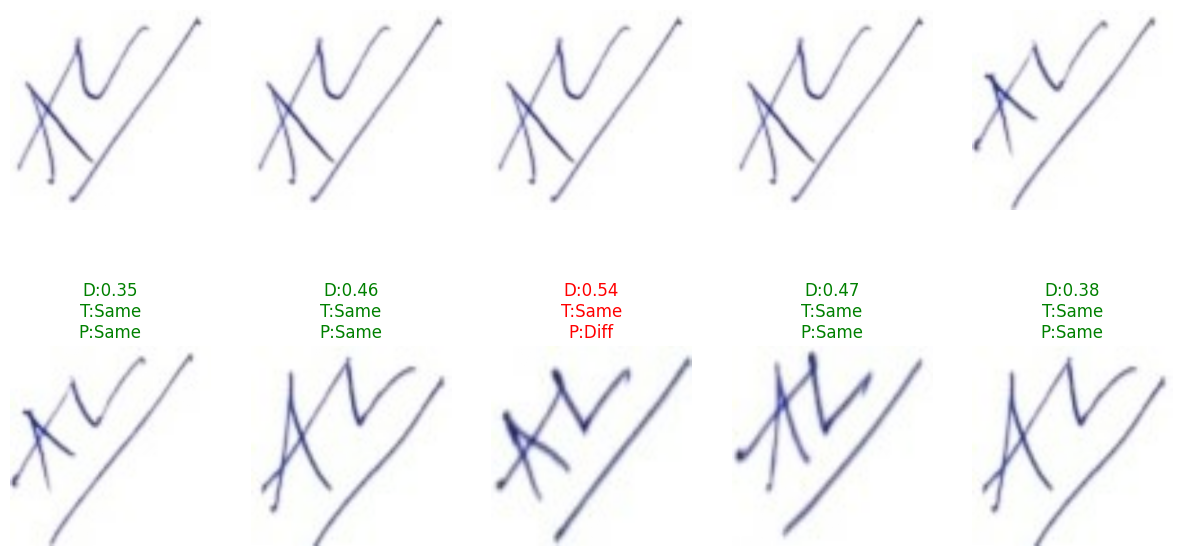

In [9]:
# Visualizing Results
def show_results(dataset, predictions, num_pairs=5):
    (img1_b, img2_b), label_b = next(iter(dataset))
    # Denormalize images for display ([-1, 1] -> [0, 1])
    img1_b = (img1_b + 1) / 2.0
    img2_b = (img2_b + 1) / 2.0
    
    batch_preds = predictions[:len(label_b)]
    
    plt.figure(figsize=(15, 8))
    for i in range(num_pairs):
        ax = plt.subplot(2, num_pairs, i + 1)
        plt.imshow(img1_b[i])
        plt.axis("off")
        
        ax = plt.subplot(2, num_pairs, i + 1 + num_pairs)
        plt.imshow(img2_b[i])
        
        dist = float(batch_preds[i])

        true_lbl = "Same" if label_b[i]==1 else "Diff"
        pred_lbl = "Same" if dist < 0.5 else "Diff"
        
        color = "green" if true_lbl == pred_lbl else "red"
        plt.title(f"D:{dist:.2f}\nT:{true_lbl}\nP:{pred_lbl}", color=color)
        plt.axis("off")
    plt.show()

show_results(test_ds, predictions)

Running Predictions for Visualization...
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 351ms/step


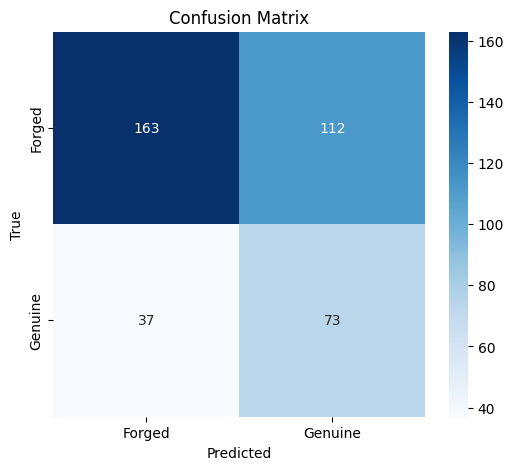

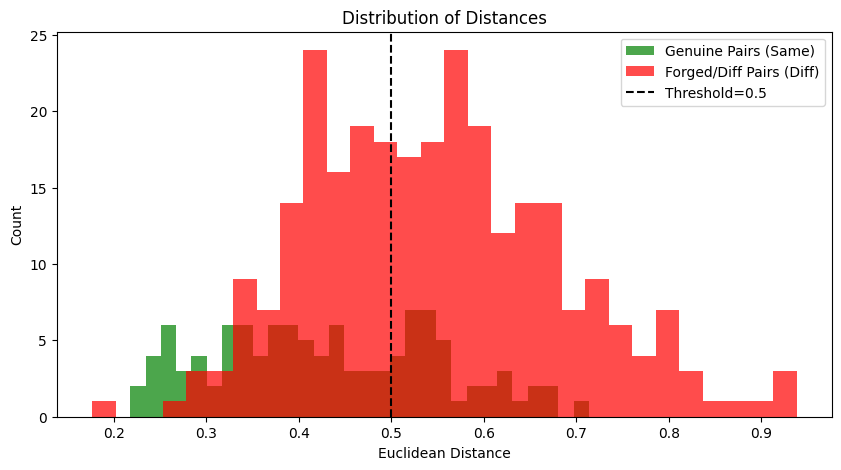

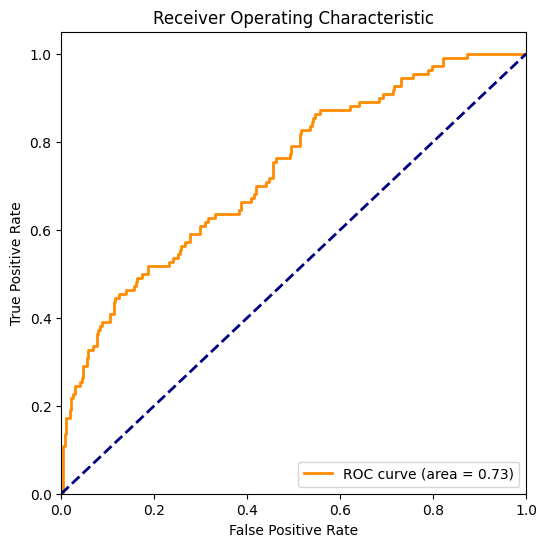

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\OMEN\AppData\Local\Temp\ipykernel_15284\1712898306.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dist = float(dists[i])


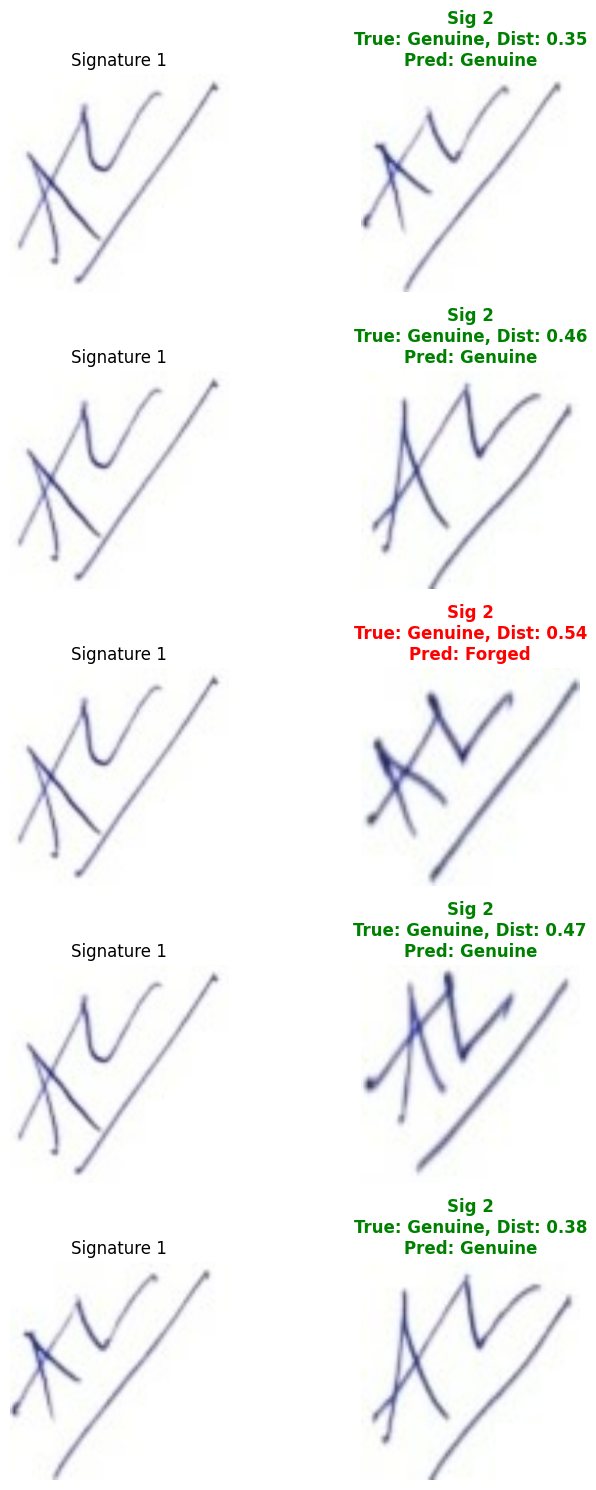

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

def evaluate_and_visualize(model, test_ds, labels, threshold=0.5):
    print("Running Predictions for Visualization...")
    predictions = model.predict(test_ds).ravel()
    
    # binary predictions
    pred_labels = (predictions < threshold).astype(int)
    
    # 1. Confusion Matrix
    cm = confusion_matrix(labels, pred_labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Forged', 'Genuine'], yticklabels=['Forged', 'Genuine'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # 2. Histograms of Distances
    pos_dist = predictions[labels == 1]
    neg_dist = predictions[labels == 0]
    
    plt.figure(figsize=(10,5))
    plt.hist(pos_dist, bins=30, alpha=0.7, label='Genuine Pairs (Same)', color='green')
    plt.hist(neg_dist, bins=30, alpha=0.7, label='Forged/Diff Pairs (Diff)', color='red')
    plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold={threshold}')
    plt.xlabel('Euclidean Distance')
    plt.ylabel('Count')
    plt.title('Distribution of Distances')
    plt.legend()
    plt.show()
    
    # 3. ROC Curve
    # Note: For distance, lower is "positive" (genuine). 
    # So we invert scores or use 1/distance for ROC logic standard, or just flip labels logic for sklearn.
    # Here, let's treat "Genuine" (1) as the positive class.
    # Distance is LOW for Genuine. So Score = -Distance (higher score = more genuine).
    fpr, tpr, _ = roc_curve(labels, -predictions)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def visualize_predictions(test_ds, model, num_pairs=5):
    # Get one batch
    # Note: test_ds is batched. We iterate manually.
    iterator = iter(test_ds)
    (img1_batch, img2_batch), y_true_batch = next(iterator)
    
    # Predict distances for this batch
    dists = model.predict([img1_batch, img2_batch])
    
    # Plot
    fig, axes = plt.subplots(num_pairs, 2, figsize=(8, 3*num_pairs))
    for i in range(num_pairs):
        # Images are normalized [-1, 1], convert back to [0, 1] for display
        im1 = (img1_batch[i] + 1) / 2.0
        im2 = (img2_batch[i] + 1) / 2.0
        
        label = "Genuine" if y_true_batch[i] == 1 else "Forged"
        dist = float(dists[i])
        pred = "Genuine" if dist < 0.5 else "Forged"
        color = "green" if label == pred else "red"
        
        axes[i, 0].imshow(im1)
        axes[i, 0].axis('off')
        axes[i, 0].set_title("Signature 1")
        
        axes[i, 1].imshow(im2)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Sig 2\nTrue: {label}, Dist: {dist:.2f}\nPred: {pred}", color=color, fontweight='bold')
        
    plt.tight_layout()
    plt.show()

# Run Evaluation
evaluate_and_visualize(siamese_model, test_ds, te_y)

# Show Examples
visualize_predictions(test_ds, siamese_model, num_pairs=5)

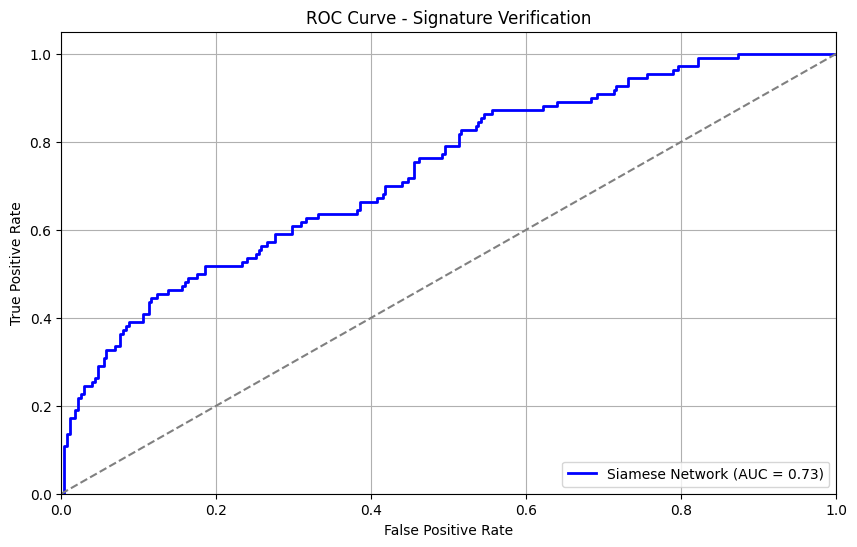

--- Metrics (Threshold=0.5) ---
FAR (False Acceptance Rate): 0.4073
FFR (False Rejection Rate):  0.3364


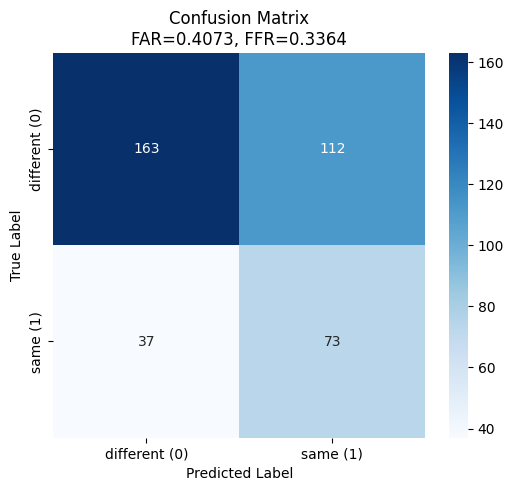

In [11]:
# --- Visualizations & Metrics ---
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare Data
# te_y: True Labels (1=Genuine Pair, 0=Forged Pair) from earlier cell
# predictions: Euclidean Distances computed in 'Evaluation' cell

# For ROC, we need a score where higher value = higher probability of being Positive (Genuine/1).
# Since our model outputs distance (Lower = Genuine), we invert it.
y_scores = -predictions.ravel()

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(te_y, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Siamese Network (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Signature Verification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 3. Confusion Matrix & FAR/FFR (Threshold = 0.5)
threshold = 0.5
# Logic: If distance < threshold => Genuine (1)
y_pred_binary = (predictions.ravel() < threshold).astype(int)

cm = confusion_matrix(te_y, y_pred_binary)
tn, fp, fn, tp = cm.ravel()

# Metrics Calculation
# Positive (1) = Genuine Pair, Negative (0) = Forged Pair

# FAR (False Acceptance Rate): Forged (0) classified as Genuine (1) -> FP / Negatives
far = fp / (fp + tn) if (fp + tn) > 0 else 0

# FFR (False Rejection Rate): Genuine (1) classified as Forged (0) -> FN / Positives
ffr = fn / (fn + tp) if (fn + tp) > 0 else 0

print(f"--- Metrics (Threshold={threshold}) ---")
print(f"FAR (False Acceptance Rate): {far:.4f}")
print(f"FFR (False Rejection Rate):  {ffr:.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['different (0)', 'same (1)'], 
            yticklabels=['different (0)', 'same (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix\nFAR={far:.4f}, FFR={ffr:.4f}')
plt.show()


Extracting embeddings for 10 users...
Computing t-SNE...


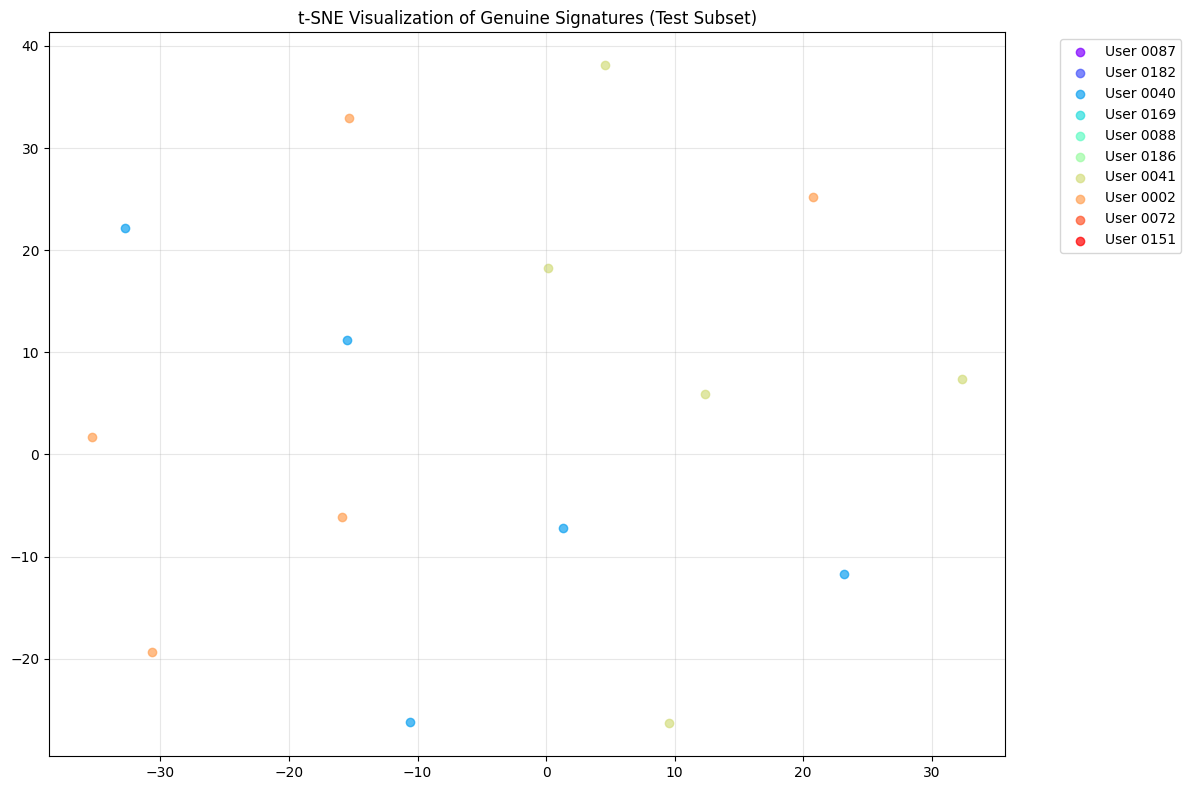

In [13]:
# 4. t-SNE Visualization of Embeddings
from sklearn.manifold import TSNE
import matplotlib.cm as cm

# Select a subset of users from Test Set to visualize
num_users_to_plot = 10
selected_users = test_ids[:num_users_to_plot]

embeddings = []
labels = []
user_labels = []

print(f"Extracting embeddings for {len(selected_users)} users...")

for i, person_id in enumerate(selected_users):
    # Get Genuine Signatures
    gen_paths = data_dict[person_id]['genuine']
    
    for path in gen_paths:
        # Preprocess
        img = preprocess_image(path, augment=False)
        img = tf.expand_dims(img, axis=0) # Add batch dim
        
        # Get Embedding
        emb = embedding_net.predict(img, verbose=0)
        embeddings.append(emb[0])
        labels.append(i) # Integer label for color
        user_labels.append(person_id)

embeddings = np.array(embeddings)
labels = np.array(labels)

# Compute t-SNE
print("Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1))
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(12, 8))
colors = cm.rainbow(np.linspace(0, 1, len(selected_users)))

for i, color in zip(range(len(selected_users)), colors):
    # Indices for this user
    idxs = labels == i
    plt.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1], 
                color=color, label=f"User {selected_users[i]}", alpha=0.7)

plt.title('t-SNE Visualization of Genuine Signatures (Test Subset)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
